In [43]:
import cv2
import numpy as np
from models import FashionMNISTModel, SVHNModel
from torch import nn 
import torch
import torchvision
from torchvision.transforms import Lambda
import pickle
from utils import create_dataloader, train_step, accuracy_fn, create_video
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

In [44]:
# # # Choose dataset
dataset_name = 'SVHN'  # Change this to 'SVHN' for SVHN dataset
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [45]:
def create_dataloader(dataset_name, root='data', train=True, download=True, transform=torchvision.transforms.ToTensor(), target_transform=None):
    if dataset_name == 'SVHN':
        data = getattr(torchvision.datasets, dataset_name)(root=root,
                                                           split='train' if train else 'test',
                                                           download=download,
                                                           transform=transform,
                                                           target_transform=target_transform)
    else:
        data = getattr(torchvision.datasets, dataset_name)(root=root,
                                                           train=train,
                                                           download=download,
                                                           transform=transform,
                                                           target_transform=target_transform)
    # Select only one sample from the dataset
    # data = torch.utils.data.Subset(data, [0])
    dataloader = DataLoader(dataset=data, batch_size=1, shuffle=True)
    return dataloader, data
train_dataloader, train_data = create_dataloader(dataset_name, train=True)

Using downloaded and verified file: data\train_32x32.mat


In [46]:
# Extract a sample from train_dataloader
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

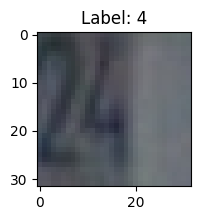

In [47]:
# Visualize the image and the label
plt.figure(figsize=(2,2))
plt.imshow(np.transpose(images[0].numpy(), (1, 2, 0)), cmap='gray')
plt.title('Label: ' + str(labels[0].item()))
plt.show()


In [48]:
if dataset_name == 'SVHN':
    class_name = [str(i) for i in range(10)]  # SVHN has 10 classes, representing digits 0-9
else:
    class_name = train_data.classes
# Choose model
if dataset_name == 'FashionMNIST':
    model = FashionMNISTModel(images.shape[0],10,len(class_name))
else:
    model = SVHNModel(len(class_name))

In [49]:
model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [50]:
# Load the model weights from pretrained_model.pth
model.load_state_dict(torch.load(f'pretrained_model_{dataset_name}.pth'))

<All keys matched successfully>

In [63]:

def train_step(model, train_data_loader,  loss_fn, optimizer, accuracy_fn, device, calculate_feat_imp=False):
    model.train()
    train_loss, train_acc = 0, 0
    feat_imp_list = []

    for batch, (X, y) in enumerate(train_data_loader):
        X, y = X.to(device), y.to(device)

        if calculate_feat_imp and X.requires_grad == False:
            X.requires_grad = True

        y_pred = model(X)
        loss = loss_fn(y_pred, y)

        if calculate_feat_imp:
            # Perform feature importance calculation before backward pass
            with torch.no_grad():
                gradients = torch.autograd.grad(outputs=y_pred, inputs=X, grad_outputs=torch.ones_like(y_pred), only_inputs=True, retain_graph=True)[0]
                feat_imp = torch.abs(gradients).mean(dim=0)
                feat_imp_list.append(feat_imp.cpu().numpy())

        train_loss += loss.item()
        train_acc += accuracy_fn(y, y_pred.argmax(dim=1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Visualize the image and the label
        plt.figure(figsize=(5,5))
        plt.imshow(np.transpose(X[0].cpu().detach().numpy(), (1, 2, 0)), cmap='gray')
        if calculate_feat_imp:
            # Overlay the feature importance map
            feat_imp = feat_imp_list[0].squeeze()
            feat_imp = cv2.normalize(feat_imp, None, 255,0, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
            if len(feat_imp.shape) == 2:  # Grayscale
                feat_imp = cv2.cvtColor(feat_imp, cv2.COLOR_GRAY2BGR)
            elif feat_imp.shape[0] == 3:  # RGB
                feat_imp = np.transpose(feat_imp, (1, 2, 0))
                feat_imp = cv2.cvtColor(feat_imp, cv2.COLOR_RGB2BGR)  # Convert RGB to BGR format
            else:
                raise ValueError("Unsupported number of channels. The image should be either grayscale or RGB.")
            feat_imp = cv2.applyColorMap(feat_imp, cv2.COLORMAP_JET)
            plt.imshow(feat_imp, alpha=0.3)
        plt.title('Label: ' + str(y[0].cpu().item()))
        plt.show()
        break

    return feat_imp_list[0] if calculate_feat_imp else model


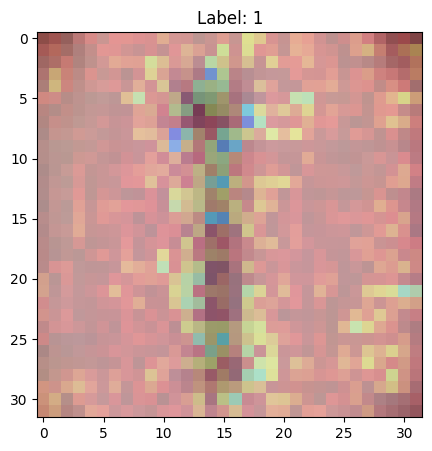

In [64]:
feat_imp = train_step(model, train_dataloader, loss_fn, optimizer, accuracy_fn, device, calculate_feat_imp=True)